In [2]:
import json
import os
import contextlib
import warnings
warnings.filterwarnings(action='ignore')

from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import ultralytics.utils.metrics as metrics
import torch

In [3]:
def get_stats(gt_path, res_path, conf=0.1, iou_thres=0.5, agnostic=False):
    gt = json.load(open(gt_path))
    pred = json.load(open(res_path))
    unique_ids = sorted(list(set([x['id'] for x in gt['images']])))
    
    gt_objects = []
    for img_id in unique_ids:
        img_annos = [x for x in gt['annotations'] if x['image_id']==img_id]

        img_bboxes = []

        for img_anno in img_annos:
            xmin,ymin,w,h = img_anno['bbox']
            xmax,ymax = xmin+w, ymin+h
            cls = img_anno['category_id']  if not agnostic else 0
            img_bboxes.append([xmin,ymin,xmax,ymax,cls])
        gt_objects.append(img_bboxes)
        
    nc = len(gt['categories']) if not agnostic else 1
        
        
    pred_objects = []
    for img_id in unique_ids:
        img_annos = [x for x in pred if x['image_id']==img_id]

        img_bboxes = []

        for img_anno in img_annos:
            xmin,ymin,w,h = img_anno['bbox']
            xmax,ymax = xmin+w, ymin+h
            cls = img_anno['category_id'] if not agnostic else 0
            score = img_anno['score']
            img_bboxes.append([xmin,ymin,xmax,ymax,score,cls])
        pred_objects.append(img_bboxes)
    assert len(pred_objects)==len(gt_objects)
    
    CM = metrics.ConfusionMatrix(nc, conf, iou_thres)
    for i in range(len(gt_objects)):

        img_gt = torch.tensor(gt_objects[i])
        img_pred = torch.tensor(pred_objects[i])

        if img_gt.numel():
            gt_bboxes = img_gt[:, :-1]
            gt_cls = img_gt[:,-1]
        else:
            gt_bboxes = torch.empty((0,4))
            gt_cls = torch.empty((0))

        CM.process_batch(img_pred, gt_bboxes, gt_cls)

    tp, fp, fn = CM.tp_fp_fn()    
    tp, fp, fn = tp.sum(), fp.sum(), fn.sum()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*(p*r)/(p+r)
    
    return tp,fp,fn,p,r,f1
    

In [4]:
def get_metrics_df(det_paths, gt_path, iou_th, max_dets, names, conf=0.1, iou_thres=0.5):
#     def get_pr(all_params):
#         recall_all = all_params['recall'][0,:,:,-1] # iou_th=0.5, max max_dets
#         mean_recall = np.mean(recall_all[recall_all>-1])

#         precision_all = all_params['precision'][0,:,:,:,-1] # iou_th=0.5, max max_dets
#         rec_ind = [[i, x] for i,x in enumerate(all_params['params'].recThrs) if x==round(mean_recall, 2)]
#         rec_ind, rec_val = rec_ind[0]

#         p = precision_all[rec_ind,:,:]
#         p = np.mean(p[p>-1])
#         return p, mean_recall
    
    
    
    all_metrics = []
    for det_path in tqdm(det_paths):

        det = json.load(open(det_path))
        # print(len(det))
        det = [x for x in det if x['score'] >= th] if th is not None else det
        # print(len(det))
        # print(max_dets, iou_th)

        th_path = det_path.replace('.json', f'-mapped.json')
        with open(th_path, 'w', encoding='utf-8') as f:
            json.dump(det, f, ensure_ascii=False, indent=4)

        method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
        # print(method, ds)

        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            anno = COCO(gt_path)
            pred = anno.loadRes(th_path)  # init predictions api
            eval = COCOeval(anno, pred, 'bbox', iouThr=iou_th, maxDets=max_dets)
            imgIds = sorted(anno.getImgIds())
            eval.params.imgIds = imgIds


            eval.evaluate()
            eval.accumulate()
            eval.summarize()
            map, map50 = eval.stats[:2]
            all_params = eval.eval
            # p,r = get_pr(all_params)
            tp,fp,fn,p,r,f1 = get_stats(gt_path, th_path, conf=conf, iou_thres=iou_thres)

        stats = {k:v for k,v in zip(names+['TP', 'FP', 'FN', 'P','R', 'F1'], [method, ds] + [x*100 for x in eval.stats.tolist()]+[tp,fp,fn]+[_*100 for _ in [p,r,f1]])}
        all_metrics.append(stats)

    metrics = pd.DataFrame(all_metrics)
    return metrics

## constants

In [5]:
th = 0.01 #0.2 #0.01

sds_gt = 'data/SeaDronesSee/test_dev.json'
names_sds = ['method', 'dataset', 'AP', 'AP50', 'AP75', 'APu', 'APvt', 'APt', 'APs', 'APm', 'APl', 'AR1', 'AR10', 'AR100', 'ARu', 'ARvt', 'ARt', 'ARs', 'ARm', 'ARl']
max_dets_sds = [1,10,100]
iou_th_sds = None

dc_gt = 'data/DroneCrowd/test_minus_val.json'
names_dc = ['method', 'dataset', 'AP', 'AP50', 'AP75', 'APu', 'APvt', 'APt', 'APs', 'APm', 'APl', 'AR500', 'ARu', 'ARvt', 'ARt', 'ARs', 'ARm', 'ARl']
max_dets_dc = [500]
iou_th_dc = 0.5

## OBS iou_ths

In [ ]:
# sds_obs = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-test_dev.json', recursive=True))
# sds_csv = 'ablation/SDS-OBS-iouths.csv'

# metrics_obs_sds = get_metrics_df(sds_obs, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
# metrics_obs_sds.to_csv(sds_csv, index=False)
metrics_obs_sds

In [6]:
m = []
for det_path in sds_obs:
    method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
    tp,fp,fn,p,r,f1 = get_stats(sds_gt, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
    m.append({
        'method': method,
        'ds': ds,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'P': p*100,
        'R': r*100,
        'F1': f1*100
    })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/SDS-OBS-iouths-basic-classes.csv')
metrics_cls

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8584/8584 [00:56<00:00, 150.98it/s]


,method,ds,TP,FP,FN,P,R,F1
0,OBS-iou,SDS-OBS-disabled,42088.0,14628.0,5590.0,74.208336,88.275515,80.632987
1,OBS-iou,SDS-OBS-th01,42034.0,7847.0,5644.0,84.268559,88.162255,86.171445
2,OBS-iou,SDS-OBS-th02,42064.0,7986.0,5614.0,84.043956,88.225177,86.083824
3,OBS-iou,SDS-OBS-th03,42052.0,8153.0,5626.0,83.760582,88.200008,85.922990
4,OBS-iou,SDS-OBS-th04,42057.0,8370.0,5621.0,83.401749,88.210495,85.738749
5,OBS-iou,SDS-OBS-th05,42073.0,8708.0,5605.0,82.851854,88.244054,85.462985
6,OBS-iou,SDS-OBS-th06,42101.0,9173.0,5577.0,82.109841,88.302781,85.093783
7,OBS-iou,SDS-OBS-th07,42143.0,9890.0,5535.0,80.992831,88.390872,84.530293
8,OBS-iou,SDS-OBS-th08,42160.0,10882.0,5518.0,79.484182,88.426528,83.717236
9,OBS-iou,SDS-OBS-th09,42164.0,12406.0,5514.0,77.265897,88.434918,82.473985


In [8]:
# m = []
# for det_path in sds_obs:
#     method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
#     tp,fp,fn,p,r,f1 = get_stats(sds_gt, det_path, conf=0.1, iou_thres=0.5, agnostic=True)
#     m.append({
#         'method': method,
#         'ds': ds,
#         'TP': tp,
#         'FP': fp,
#         'FN': fn,
#         'P': p*100,
#         'R': r*100,
#         'F1': f1*100
#     })
    
# metrics_agn = pd.DataFrame(m)
# metrics_agn.to_csv('ablation/SDS-OBS-iouths-basic-agnostic.csv')
# metrics_agn

In [9]:
dc_obs = glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/OBS-iou/**/results-test_minus_val.json', recursive=True)
dc_csv = 'ablation/DC-OBS-iouths.csv'

In [10]:
m = []
for det_path in dc_obs:
    method, ds = os.path.dirname(det_path).split(os.sep)[-2:]
    tp,fp,fn,p,r,f1 = get_stats(dc_gt, det_path, conf=0.1, iou_thres=0.5, agnostic=False)
    m.append({
        'method': method,
        'ds': ds,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'P': p*100,
        'R': r*100,
        'F1': f1*100
    })
    
metrics_cls = pd.DataFrame(m)
metrics_cls.to_csv('ablation/DC-OBS-iouths-basic-classes.csv')
metrics_cls

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8640/8640 [26:46<00:00,  5.38it/s]


,method,ds,TP,FP,FN,P,R,F1
0,OBS-iou,DC-OBS-disabled,748260.0,842218.0,433678.0,47.046234,63.307889,53.978912
1,OBS-iou,DC-OBS-th05,712824.0,592468.0,469114.0,54.610309,60.309762,57.318704


In [12]:
metrics_obs_dc = get_metrics_df(dc_obs, dc_gt, iou_th_dc, max_dets_dc, names_dc)
metrics_obs_dc.to_csv(dc_csv, index=False)
metrics_obs_dc

  0%|                                                                                                                                           | 0/2 [00:45<?, ?it/s]

KeyboardInterrupt



## SDS models

In [16]:
sds = sorted(glob('/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/compare-SDS/**/results-test_dev.json', recursive=True))
sds_csv = 'ablation/SDS-yolo-models.csv'

metrics_sds_models = get_metrics_df(sds, sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
metrics_sds_models.to_csv(sds_csv, index=False)
metrics_sds_models

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:26<00:00, 245.30s/it]


,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,compare-SDS,004-tiny-100ep-best,51.160605,83.933229,54.988920,-100.0,35.182659,48.285822,60.097395,38.799307,...,59.789171,68.415319,45.488172,67.059677,42412.0,11512.0,5266.0,78.651435,88.955074,83.486546
1,compare-SDS,004-tiny-100ep-last,51.424400,83.839138,54.984125,-100.0,35.722225,48.040617,60.200531,39.484210,...,59.690860,68.232501,46.268207,67.659828,42349.0,11088.0,5329.0,79.250332,88.822937,83.764031
2,compare-SDS,005-v7,51.725204,84.402441,54.818483,-100.0,32.645801,49.761630,60.181680,41.132546,...,60.994954,68.173954,47.941232,75.076336,42340.0,11892.0,5338.0,78.071987,88.804061,83.092925
3,compare-SDS,006-tiny-300ep,52.746991,84.747987,57.266248,-100.0,34.561255,51.217965,61.823655,37.738806,...,61.980708,70.000509,44.471645,72.508548,42782.0,12755.0,4896.0,77.033329,89.731113,82.898803
4,compare-SDS,007-tiny-100ep-bigger,51.677264,84.357516,55.701838,-100.0,35.618115,47.856213,61.395898,39.053268,...,59.464247,69.712267,45.215177,68.692351,42641.0,11586.0,5037.0,78.634260,89.435379,83.687748


## ROI - resize vs sliding window

In [17]:
results_roi = [
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-resize/results-test_dev.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-sw/results-test_dev.json',
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-resize-dilate/results-test_dev.json',
    # '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/SDS-sw-dilate/results-test_dev.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-resize/results-test_minus_val.json',
    '/home/kos/projects/PhD/EAAI/3rdparty/tinyROI/ablation/ROI-RES-VS-SW/DC-sw/results-test_minus_val.json'
]

roi_csv = 'ablation/SDS-DC-ROI-sw-vs-resize.csv'
    
metrics_roi_sds = get_metrics_df([x for x in results_roi if 'SDS' in x], sds_gt, iou_th_sds, max_dets_sds, names_sds, conf=0.1, iou_thres=0.5)
metrics_roi_dc = get_metrics_df([x for x in results_roi if 'DC' in x], dc_gt, iou_th_dc, max_dets_dc, names_dc, conf=0.1, iou_thres=0.5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [12:52:03<00:00, 23161.63s/it]


In [18]:
metrics_roi = pd.concat([metrics_roi_sds, metrics_roi_dc], ignore_index=True)
metrics_roi.to_csv(roi_csv, index=False)
metrics_roi

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARs,ARm,ARl,TP,FP,FN,P,R,F1,AR500
0,ROI-RES-VS-SW,SDS-resize,51.424400,83.839138,54.984125,-100.0,35.722225,48.040617,60.200531,39.484210,...,68.232501,46.268207,67.659828,42349.0,11088.0,5329.0,79.250332,88.822937,83.764031,NaN
1,ROI-RES-VS-SW,SDS-sw,50.910346,83.289816,54.305152,-100.0,35.700501,48.176076,60.170043,36.933359,...,68.169473,44.988102,24.326495,42055.0,12703.0,5623.0,76.801563,88.206301,82.109805,NaN
2,ROI-RES-VS-SW,DC-resize,21.427790,51.205092,13.964329,-100.0,53.060062,22.360378,-100.000000,-100.000000,...,-100.000000,-100.000000,-100.000000,751889.0,971955.0,430049.0,43.616998,63.614927,51.751233,72.273419
3,ROI-RES-VS-SW,DC-sw,22.030572,52.260221,14.595546,-100.0,52.632001,43.257883,-100.000000,-100.000000,...,-100.000000,-100.000000,-100.000000,752419.0,911141.0,429519.0,45.229448,63.659769,52.884873,72.706859


In [21]:
names = [x.rstrip() for x in open('/home/kos/Downloads/mtsd001.names')]
len(names), names[0]

(314, 'warning--double-curve-first-right--g2')

In [23]:
cat_names = json.load(open('data/MTSD/val.json'))['categories']

len(cat_names), cat_names[0]

(314,
 {'id': 0,
  'name': 'warning--double-curve-first-right--g2',
  'supercategory': 'warning'})

In [24]:
for cat_name, name in zip(cat_names, names):
    assert cat_name['name']==name, print(cat_name['name'], name)

In [7]:
metrics_sds_roi_size = pd.read_csv('ablation/SDS-seg-res.csv')
metrics_sds_roi_size

,method,dataset,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,SEG-RES,SDS-roi-large,50.574389,83.390200,54.283053,-100.0,33.109244,47.661440,58.781213,38.313543,...,59.290419,66.747107,44.556447,63.955550,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146
1,SEG-RES,SDS-roi-medium,50.660284,83.197517,54.369686,-100.0,34.569236,47.365620,59.452470,38.101579,...,57.951482,66.758314,44.039685,66.700064,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
2,SEG-RES,SDS-roi-small,47.236878,76.023740,51.361165,-100.0,24.527248,43.690880,60.181650,38.773203,...,53.643089,67.023428,43.916678,70.290633,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
3,SEG-RES,SDS-roi-tiny,38.062768,59.601752,41.561434,-100.0,10.356607,30.632313,59.714309,36.148309,...,37.251770,66.013101,40.530851,70.746859,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
4,SEG-RES,SDS-roi_track-large,50.262606,83.660235,53.684276,-100.0,35.583414,47.393074,58.508476,35.729556,...,59.673971,66.651019,42.706817,54.699626,42201.0,10967.0,5477.0,79.372931,88.512521,83.693949
5,SEG-RES,SDS-roi_track-medium,50.604422,83.430181,54.490949,-100.0,35.225827,47.605368,59.161656,35.917936,...,59.687725,66.600964,42.226580,58.337508,42016.0,11276.0,5662.0,78.841102,88.124502,83.224720
6,SEG-RES,SDS-roi_track-small,49.812678,81.762503,53.769187,-100.0,34.064308,45.479757,59.494715,36.706700,...,57.346226,66.560764,42.447600,61.014830,41406.0,9904.0,6272.0,80.697720,86.845086,83.658625
7,SEG-RES,SDS-roi_track-tiny,48.640029,78.941984,52.836494,-100.0,28.142612,44.332099,59.861395,36.158549,...,56.376180,66.606849,41.623197,63.967677,40002.0,8796.0,7676.0,81.974671,83.900331,82.926324
8,SEG-RES,SDS-roi_track_bintrk-large,50.853692,84.260094,54.352871,-100.0,35.432676,47.563658,58.740806,38.109756,...,59.423977,66.788740,43.908420,67.295245,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765
9,SEG-RES,SDS-roi_track_bintrk-medium,51.116020,84.322917,54.558613,-100.0,34.996998,48.331997,59.404534,37.874706,...,59.382263,66.828857,43.378961,67.749682,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298


In [8]:
metrics_sds_roi_size['method'] = metrics_sds_roi_size.apply(lambda x: x.dataset.split('-')[1], axis=1)
metrics_sds_roi_size['dataset'] = metrics_sds_roi_size.apply(lambda x: x.dataset.split('-')[-1], axis=1)
metrics_sds_roi_size = metrics_sds_roi_size.rename(columns={'dataset': 'input size'})
metrics_sds_roi_size['input size'] = metrics_sds_roi_size['input size'].replace({'tiny': '64x96', 'small': '128x192', 'medium': '224x384', 'large': '448x768'})

metrics_sds_roi_size

,method,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,roi,448x768,50.574389,83.390200,54.283053,-100.0,33.109244,47.661440,58.781213,38.313543,...,59.290419,66.747107,44.556447,63.955550,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146
1,roi,224x384,50.660284,83.197517,54.369686,-100.0,34.569236,47.365620,59.452470,38.101579,...,57.951482,66.758314,44.039685,66.700064,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
2,roi,128x192,47.236878,76.023740,51.361165,-100.0,24.527248,43.690880,60.181650,38.773203,...,53.643089,67.023428,43.916678,70.290633,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
3,roi,64x96,38.062768,59.601752,41.561434,-100.0,10.356607,30.632313,59.714309,36.148309,...,37.251770,66.013101,40.530851,70.746859,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
4,roi_track,448x768,50.262606,83.660235,53.684276,-100.0,35.583414,47.393074,58.508476,35.729556,...,59.673971,66.651019,42.706817,54.699626,42201.0,10967.0,5477.0,79.372931,88.512521,83.693949
5,roi_track,224x384,50.604422,83.430181,54.490949,-100.0,35.225827,47.605368,59.161656,35.917936,...,59.687725,66.600964,42.226580,58.337508,42016.0,11276.0,5662.0,78.841102,88.124502,83.224720
6,roi_track,128x192,49.812678,81.762503,53.769187,-100.0,34.064308,45.479757,59.494715,36.706700,...,57.346226,66.560764,42.447600,61.014830,41406.0,9904.0,6272.0,80.697720,86.845086,83.658625
7,roi_track,64x96,48.640029,78.941984,52.836494,-100.0,28.142612,44.332099,59.861395,36.158549,...,56.376180,66.606849,41.623197,63.967677,40002.0,8796.0,7676.0,81.974671,83.900331,82.926324
8,roi_track_bintrk,448x768,50.853692,84.260094,54.352871,-100.0,35.432676,47.563658,58.740806,38.109756,...,59.423977,66.788740,43.908420,67.295245,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765
9,roi_track_bintrk,224x384,51.116020,84.322917,54.558613,-100.0,34.996998,48.331997,59.404534,37.874706,...,59.382263,66.828857,43.378961,67.749682,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298


In [9]:
metrics_roi = metrics_sds_roi_size[metrics_sds_roi_size.method=='roi'][[x for x in metrics_sds_roi_size.columns if x != 'method']]
metrics_roi = metrics_roi.sort_values(by='input size', key = lambda col: [int(x.split('x')[0]) for x in col])
metrics_roi_track = metrics_sds_roi_size[metrics_sds_roi_size.method=='roi_track_bintrk'][[x for x in metrics_sds_roi_size.columns if x != 'method']]
metrics_roi_track = metrics_roi_track.sort_values(by='input size', key = lambda col: [int(x.split('x')[0]) for x in col])

In [10]:
metrics_roi

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
3,64x96,38.062768,59.601752,41.561434,-100.0,10.356607,30.632313,59.714309,36.148309,63.771530,...,37.251770,66.013101,40.530851,70.746859,31367.0,4985.0,16311.0,86.286862,65.789253,74.656670
2,128x192,47.236878,76.023740,51.361165,-100.0,24.527248,43.690880,60.181650,38.773203,65.183429,...,53.643089,67.023428,43.916678,70.290633,39025.0,7883.0,8653.0,83.194764,81.851168,82.517497
1,224x384,50.660284,83.197517,54.369686,-100.0,34.569236,47.365620,59.452470,38.101579,63.054105,...,57.951482,66.758314,44.039685,66.700064,41850.0,9790.0,5828.0,81.041828,87.776333,84.274754
0,448x768,50.574389,83.390200,54.283053,-100.0,33.109244,47.661440,58.781213,38.313543,61.419307,...,59.290419,66.747107,44.556447,63.955550,41845.0,9765.0,5833.0,81.079248,87.765846,84.290146


In [87]:
fps.to_csv('ablation/seg-res-FPS.csv', index=False)

In [18]:
fps = pd.read_csv('ablation/seg-res-FPS.csv')
fps['time-track'] = fps['time-track'] / 4
fps

,model,time-SEG,time-track
0,64x96,0.002360,0.000578
1,128x192,0.002650,0.000640
2,224x384,0.005111,0.000779
3,448x768,0.012169,0.000728


In [88]:
#fps['time-sum'] = fps['time-SEG']+fps['time-track']

# fps['FPS-SEG'] = fps.apply(lambda x: 1/x['time-SEG'], axis=1)
fps['FPS-TRACK'] = fps.apply(lambda x: 1/x['time-track'], axis=1)
# fps['FPS-SUM'] = fps.apply(lambda x: 1/x['time-sum'], axis=1)

fps

,model,time-SEG,time-track,time-sum,FPS-SEG,FPS-TRACK,FPS-SUM
0,64x96,0.002360,0.000578,0.002938,423.728814,1731.175121,340.409040
1,128x192,0.002650,0.000640,0.003290,377.358491,1563.517248,303.989842
2,224x384,0.005111,0.000779,0.005890,195.656427,1284.262327,169.789171
3,448x768,0.012169,0.000728,0.012897,82.176021,1373.261875,77.536250


In [29]:
times = {}

for i in range(len(fps)):
    fps_ = fps.iloc[i]
    times[fps_['model']] = f"SEG {int(fps_['FPS-SEG'])} FPS\nSEG+TRACK {int(fps_['FPS-SUM'])} FPS"
times

{'64x96': 'SEG 423 FPS\nSEG+TRACK 340 FPS',
 '128x192': 'SEG 377 FPS\nSEG+TRACK 303 FPS',
 '224x384': 'SEG 195 FPS\nSEG+TRACK 169 FPS',
 '448x768': 'SEG 82 FPS\nSEG+TRACK 77 FPS'}

In [25]:
metrics_roi_track

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
11,64x96,48.218176,77.482743,52.496244,-100.0,25.995918,44.454804,59.831521,37.648284,62.944379,...,54.532581,66.471935,42.363876,70.746859,39192.0,6921.0,8486.0,84.991217,82.201435,83.573051
10,128x192,50.535369,82.395952,54.601561,-100.0,33.839651,46.562280,60.064747,38.756527,64.444521,...,57.146604,66.970387,43.731009,70.615060,41564.0,8588.0,6114.0,82.876057,87.176476,84.971890
9,224x384,51.116020,84.322917,54.558613,-100.0,34.996998,48.331997,59.404534,37.874706,64.014560,...,59.382263,66.828857,43.378961,67.749682,42207.0,10238.0,5471.0,80.478597,88.525106,84.310298
8,448x768,50.853692,84.260094,54.352871,-100.0,35.432676,47.563658,58.740806,38.109756,63.946016,...,59.423977,66.788740,43.908420,67.295245,42214.0,10272.0,5464.0,80.429067,88.539788,84.289765


In [26]:
diff = metrics_roi_track.set_index(['input size']).subtract(metrics_roi.set_index(['input size']), fill_value=0)
diff = diff.reset_index()
diff

,input size,AP,AP50,AP75,APu,APvt,APt,APs,APm,APl,...,ARt,ARs,ARm,ARl,TP,FP,FN,P,R,F1
0,64x96,10.155408,17.880991,10.934810,0.0,15.639311,13.822491,0.117212,1.499974,-0.827151,...,17.280812,0.458834,1.833025,0.000000,7825.0,1936.0,-7825.0,-1.295645,16.412182,8.916380
1,128x192,3.298491,6.372212,3.240397,0.0,9.312404,2.871400,-0.116903,-0.016675,-0.738908,...,3.503515,-0.053041,-0.185668,0.324427,2539.0,705.0,-2539.0,-0.318707,5.325307,2.454393
2,224x384,0.455736,1.125400,0.188928,0.0,0.427762,0.966377,-0.047935,-0.226872,0.960455,...,1.430781,0.070543,-0.660724,1.049618,357.0,448.0,-357.0,-0.563231,0.748773,0.035545
3,448x768,0.279304,0.869894,0.069818,0.0,2.323432,-0.097782,-0.040407,-0.203787,2.526709,...,0.133558,0.041633,-0.648028,3.339695,369.0,507.0,-369.0,-0.650181,0.773942,-0.000381


In [75]:
fps

,model,time-SEG,time-track,time-sum,FPS-SEG,FPS-TRACK,FPS-SUM
0,64x96,0.002360,0.000578,0.002938,423.728814,1731.175121,340.409040
1,128x192,0.002650,0.000640,0.003290,377.358491,1563.517248,303.989842
2,224x384,0.005111,0.000779,0.005890,195.656427,1284.262327,169.789171
3,448x768,0.012169,0.000728,0.012897,82.176021,1373.261875,77.536250


In [83]:
from tabulate import tabulate

In [84]:
table_header = ['size', 'APs', 'APst', 'AR10s', 'AR10st', 'FPSs', 'FPSst']

rows = []

for i in range(len(diff)):
    s = metrics_roi.iloc[i]
    st = metrics_roi_track.iloc[i]
    d = diff.iloc[i]
    
    size = d['input size']
    aps, apst, apd = s.AP, st.AP, d.AP
    ars, arst, ard = s.AR10, st.AR10, d.AR10
    print(size, aps, apst, apd, ars, arst, ard)
    
    fpss, fpsst = int(fps.iloc[i]['FPS-SEG']), int(fps.iloc[i]['FPS-SUM'])
    fpsd = fpsst-fpss
    
    rows.append([
        size,
        f'{aps:.1f}',
        f'{apst:.1f} (+{apd:.1f})',
        f'{ars:.1f}',
        f'{arst:.1f} (+{ard:.1f})',
        f'{fpss}',
        f'{fpsst} ({fpsd})',
        
    ])

open('../../tables/seg-size.tex', 'w').write(tabulate(rows, table_header, tablefmt='latex', stralign='center', numalign='left', floatfmt=".1f"))

64x96 38.06276750641179 48.218175866396415 10.155408359984627 42.94437447706102 55.40871429046384 12.464339813402823
128x192 47.23687781736185 50.5353686867098 3.298490869347951 54.44307569788304 58.412801734737904 3.9697260368548655
224x384 50.660284426557 51.11602033220638 0.4557359056493837 58.82547999552036 59.59276673824105 0.7672867427206924
448x768 50.57438866570555 50.85369249730742 0.27930383160187233 59.45826316428698 59.66409243035434 0.2058292660673544


464

In [86]:
print(tabulate(rows, table_header)) #, tablefmt='latex', stralign='center', numalign='left', floatfmt=".1f")

size       APs  APst            AR10s  AR10st          FPSs  FPSst
-------  -----  ------------  -------  ------------  ------  ---------
64x96     38.1  48.2 (+10.2)     42.9  55.4 (+12.5)     423  340 (-83)
128x192   47.2  50.5 (+3.3)      54.4  58.4 (+4.0)      377  303 (-74)
224x384   50.7  51.1 (+0.5)      58.8  59.6 (+0.8)      195  169 (-26)
448x768   50.6  50.9 (+0.3)      59.5  59.7 (+0.2)       82  77 (-5)


['64x96\nSEG 423 FPS\nSEG+TRACK 340 FPS', '128x192\nSEG 377 FPS\nSEG+TRACK 303 FPS', '224x384\nSEG 195 FPS\nSEG+TRACK 169 FPS', '448x768\nSEG 82 FPS\nSEG+TRACK 77 FPS']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

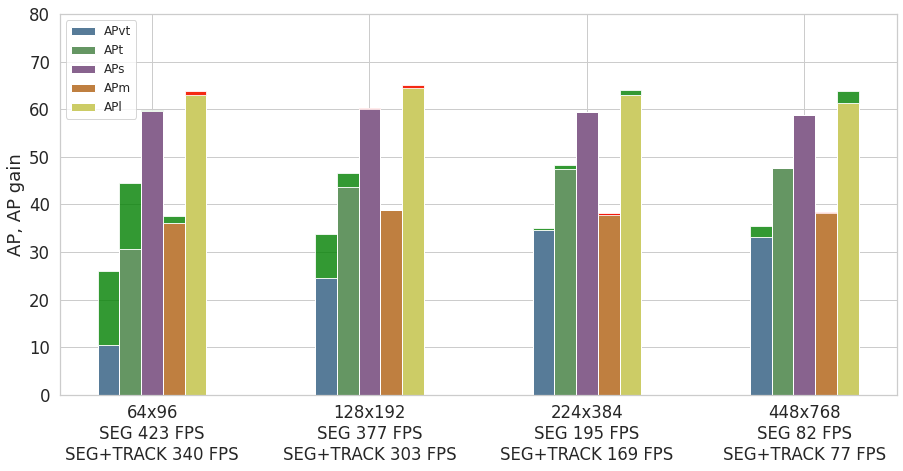

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ['64x96', '128x192', '224x384', '448x768']
aps = ['APvt', 'APt', 'APs', 'APm', 'APl'] #, 'AP', 'AP50', 'AP75'] #[x for x in diff.columns if 'AP' in x and 'APu' not in x]
ars = ['ARvt', 'ARt', 'ARs', 'ARm', 'ARl'] #, 'AR10'] #[x for x in diff.columns if 'AR' in x and 'ARu' not in x and x!='AR1' and x!='AR100']


sns.set(style = 'whitegrid', font_scale = 1.5)
palette = sns.color_palette("Set1", n_colors=9, desat=0.5)
palette = palette[1:]
sns.set_palette(palette)

# sns.set_palette(sns.color_palette("Set1", desat=0.5))

plt.tight_layout()
plt.figure(figsize=(15,7))
ax  = plt.gca()

N = len(models)
ind = np.arange(N)  # the x locations for the groups
width = 0.1  # the width of the bars


rects_base = []
rects_diff = []
for I, ap_name in enumerate(aps):
    roi_values = metrics_roi[ap_name].values
    roi_track_values = metrics_roi_track[ap_name].values
    diff_values = diff[ap_name].values
    
    bottoms, values, colors = [], [], []
    for d, diff_value in enumerate(diff_values):
        if diff_value < 0:
            bottom = roi_track_values[d]
            value = abs(diff_value)
            color = 'red'
        else:
            bottom = roi_values[d]
            value = diff_value
            color = 'green'
        bottoms.append(bottom); values.append(value); colors.append(color)

    rect_base = plt.bar(ind+I*width, roi_values, width)
    rects_base.append(rect_base)
    
    for i, rect in enumerate(rect_base):
        plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i], alpha=0.8)

# plt.xlabel('model input size')
plt.ylabel('AP, AP gain')
plt.ylim([0,80])

xticks = [f'{model}\n{times[model]}' for model in models]
print(xticks)

plt.xticks(ind + 2*width, xticks, rotation=0)
_ = plt.legend( [rect[0] for rect in rects_base], aps, loc='upper left', fontsize=12)
plt.savefig('../../plots/SDS-seg-res-bin-trk.png',bbox_inches='tight', pad_inches=0)
plt.savefig('../../plots/SDS-seg-res-bin-trk.eps',bbox_inches='tight', pad_inches=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

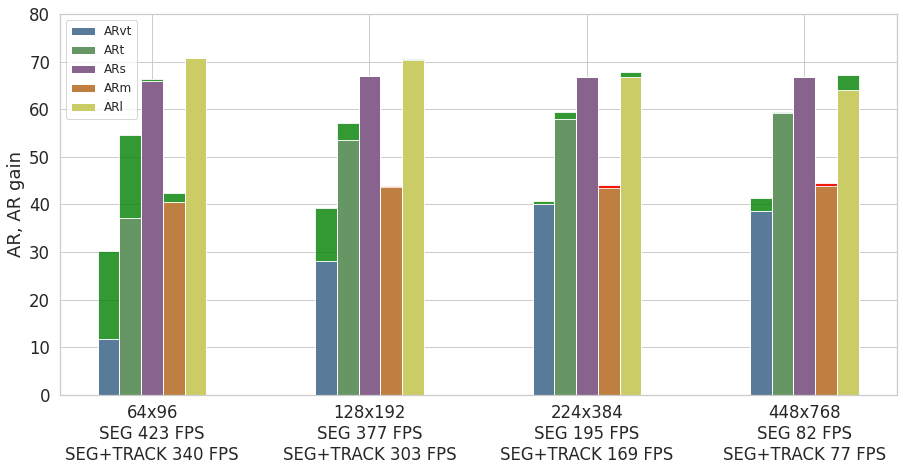

In [71]:
sns.set(style = 'whitegrid', font_scale = 1.5)
sns.set_palette(palette)

plt.tight_layout()
plt.figure(figsize=(15,7))
ax  = plt.gca()

N = len(models)
ind = np.arange(N)  # the x locations for the groups
width = 0.1  # the width of the bars


rects_base = []
rects_diff = []
for I, ap_name in enumerate(ars):
    roi_values = metrics_roi[ap_name].values
    roi_track_values = metrics_roi_track[ap_name].values
    diff_values = diff[ap_name].values
    
    bottoms, values, colors = [], [], []
    for d, diff_value in enumerate(diff_values):
        if diff_value < 0:
            bottom = roi_track_values[d]
            value = abs(diff_value)
            color = 'red'
        else:
            bottom = roi_values[d]
            value = diff_value
            color = 'green'
        bottoms.append(bottom); values.append(value); colors.append(color)

    rect_base = plt.bar(ind+I*width, roi_values, width)
    rects_base.append(rect_base)
    
    for i, rect in enumerate(rect_base):
        plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i], alpha=0.8)

# plt.xlabel('model input size')
plt.ylabel('AR, AR gain')
plt.ylim([0,80])
plt.xticks(ind + 2*width, xticks, rotation=0)
_ = plt.legend( [rect[0] for rect in rects_base], ars, loc='upper left', fontsize=12)

plt.savefig('../../plots/SDS-seg-res-bin-trk-ar.png',bbox_inches='tight', pad_inches=0)
plt.savefig('../../plots/SDS-seg-res-bin-trk-ar.eps',bbox_inches='tight', pad_inches=0)

In [125]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from collections import OrderedDict

# models = ['64x96', '128x192', '224x384', '448x768']
# aps = ['APvt', 'APt', 'APs', 'APm', 'APl', 'AP', 'AP50', 'AP75'] #[x for x in diff.columns if 'AP' in x and 'APu' not in x]
# ars = ['ARvt', 'ARt', 'ARs', 'ARm', 'ARl', 'AR10'] #[x for x in diff.columns if 'AR' in x and 'ARu' not in x and x!='AR1' and x!='AR100']


# sns.set(style = 'whitegrid', font_scale = 1.2)
# # sns.set_palette(sns.color_palette("Set1", desat=0.5))

# plt.tight_layout()
# plt.figure(figsize=(12,5.5))
# ax  = plt.gca()

# N = len(models)
# ind = np.arange(N)  # the x locations for the groups
# width = 0.1  # the width of the bars


# rects_base = []
# rects_diff = []
# for I, ap_name in enumerate(aps):
#     roi_values = metrics_roi[ap_name].values
#     roi_track_values = metrics_roi_track[ap_name].values
#     diff_values = diff[ap_name].values
    
#     bottoms, values, colors = [], [], []
#     for d, diff_value in enumerate(diff_values):
#         if diff_value < 0:
#             bottom = roi_track_values[d]
#             value = abs(diff_value)
#             color = 'red'
#         else:
#             bottom = roi_values[d]
#             value = diff_value
#             color = 'green'
#         bottoms.append(bottom); values.append(value); colors.append(color)

#     rect_base = plt.bar(ind+I*width, roi_values, width)
#     rects_base.append(rect_base)
    
#     for i, rect in enumerate(rect_base):
#         plt.bar(x = rect.xy[0]+0.5*width, height=values[i], width=width, bottom=bottoms[i], color=colors[i])

# plt.ylim([0,100])
# plt.xticks(ind + 3.5*width, models, rotation=0)
# _ = plt.legend( [rect[0] for rect in rects_base], aps)
# plt.savefig('../../plots/SDS-seg-res.png',bbox_inches='tight', pad_inches=0)